In [1]:
import torch
from torch import nn
import dltools

In [2]:
batch_size, max_len = 1, 64
train_iter, vocab = dltools.load_data_wiki(batch_size, max_len)

In [46]:
# tokens, segments, valid_lens, pred_positions, mlm_weights,mlm, nsp
for i in train_iter:
    break
i

[tensor([[    3,     2,     2,  6488,    59,   563,  1635,     7,     5,   105,
           1147,     6,     5,   165,   140,    21,     2,   791,  1956,    20,
            360,   688,     4,    15,     2,   563,   236,     2,   109,     6,
          11517,    19,     2,   401, 11779,     5,   755,   409,     4,     1,
              1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
              1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
              1,     1,     1,     1]]),
 tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
          1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]),
 tensor([39.]),
 tensor([[ 1,  2, 16, 24, 27, 32,  0,  0,  0,  0]]),
 tensor([[1., 1., 1., 1., 1., 1., 0., 0., 0., 0.]]),
 tensor([[   15,     5,    77,     5,     6, 11610,     0,     0,     0,     0]]),
 tensor([1])]

In [23]:
net = dltools.BERTModel(len(vocab), num_hiddens=128, norm_shape=[128],
                    ffn_num_input=128, ffn_num_hiddens=256, num_heads=2,
                    num_layers=2, dropout=0.2, key_size=128, query_size=128,
                    value_size=128, hid_in_features=128, mlm_in_features=128,
                    nsp_in_features=128)
devices = dltools.try_all_gpus()
loss = nn.CrossEntropyLoss()

In [47]:
#@save
def _get_batch_loss_bert(net, loss, vocab_size, tokens_X,segments_X, valid_lens_x,pred_positions_X, mlm_weights_X,mlm_Y, nsp_y):
    # 前向传播
    _, mlm_Y_hat, nsp_Y_hat = net(tokens_X, segments_X,valid_lens_x.reshape(-1),pred_positions_X)
    # 计算遮蔽语言模型损失
    mlm_l = loss(mlm_Y_hat.reshape(-1, vocab_size), mlm_Y.reshape(-1)) * mlm_weights_X.reshape(-1, 1)
    mlm_l = mlm_l.sum() / (mlm_weights_X.sum() + 1e-8)
    # 计算下一句子预测任务的损失
    nsp_l = loss(nsp_Y_hat, nsp_y)
    l = mlm_l + nsp_l
    return mlm_l, nsp_l, l

In [48]:
def train_bert(train_iter, net, loss, vocab_size, devices, num_steps):
    net = nn.DataParallel(net, device_ids=devices).to(devices[0])
    trainer = torch.optim.Adam(net.parameters(), lr=0.01)
    step, timer = 0, dltools.Timer()
    animator = dltools.Animator(xlabel='step', ylabel='loss',xlim=[1, num_steps], legend=['mlm', 'nsp'])
    # 遮蔽语言模型损失的和，下一句预测任务损失的和，句子对的数量，计数
    metric = dltools.Accumulator(4)
    num_steps_reached = False
    while step < num_steps and not num_steps_reached:
        for tokens_X, segments_X, valid_lens_x, pred_positions_X,mlm_weights_X, mlm_Y, nsp_y in train_iter:
            tokens_X = tokens_X.to(devices[0])
            segments_X = segments_X.to(devices[0])
            valid_lens_x = valid_lens_x.to(devices[0])
            pred_positions_X = pred_positions_X.to(devices[0])
            mlm_weights_X = mlm_weights_X.to(devices[0])
            mlm_Y, nsp_y = mlm_Y.to(devices[0]), nsp_y.to(devices[0])
            trainer.zero_grad()
            timer.start()
            mlm_l, nsp_l, l = _get_batch_loss_bert(net, loss, vocab_size, tokens_X, segments_X, valid_lens_x,pred_positions_X, mlm_weights_X, mlm_Y, nsp_y)
            l.backward()
            trainer.step()
            metric.add(mlm_l, nsp_l, tokens_X.shape[0], 1)
            timer.stop()
            animator.add(step + 1,(metric[0] / metric[3], metric[1] / metric[3]))
            step += 1
            if step == num_steps:
                num_steps_reached = True
                break

    print(f'MLM loss {metric[0] / metric[3]:.3f}, 'f'NSP loss {metric[1] / metric[3]:.3f}')
    print(f'{metric[2] / timer.sum():.1f} sentence pairs/sec on 'f'{str(devices)}')

MLM loss 7.139, NSP loss 0.998
5.8 sentence pairs/sec on [device(type='cpu')]


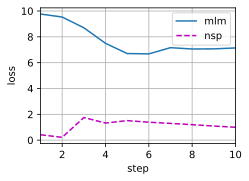

In [49]:
train_bert(train_iter, net, loss, len(vocab), devices,10)

In [27]:
def get_bert_encoding(net, tokens_a, tokens_b=None):
    tokens, segments = dltools.get_tokens_and_segments(tokens_a, tokens_b)
    token_ids = torch.tensor(vocab[tokens], device=devices[0]).unsqueeze(0)
    segments = torch.tensor(segments, device=devices[0]).unsqueeze(0)
    valid_len = torch.tensor(len(tokens), device=devices[0]).unsqueeze(0)
    encoded_X, _, _ = net(token_ids, segments, valid_len)
    return encoded_X

In [38]:
tokens_a = ['a', 'crane', 'is', 'flying']
encoded_text = get_bert_encoding(net, tokens_a)
# 词元：'<cls>','a','crane','is','flying','<sep>'
encoded_text_cls = encoded_text[:, 0, :]
encoded_text_crane = encoded_text[:, 2, :]
encoded_text.shape, encoded_text_cls.shape, encoded_text_crane[0][:3]

(torch.Size([1, 6, 128]),
 torch.Size([1, 128]),
 tensor([-0.0428, -0.2375, -0.3204], grad_fn=<SliceBackward0>))

In [39]:
encoded_text_crane

tensor([[-0.0428, -0.2375, -0.3204, -0.4058,  0.1068,  0.4373, -1.3550,  0.0430,
         -2.1844, -0.8609,  1.7404,  0.9848,  0.7038, -0.0291, -0.5989,  1.2844,
         -0.0565, -0.5014, -1.2710,  1.0842,  0.0572,  0.8628,  1.9570,  1.1471,
         -0.6657,  0.1830,  1.2501,  2.3783, -1.3074,  0.1920,  0.0539,  0.0663,
         -0.1515,  0.0316, -0.2654,  0.0431, -0.0161, -0.1885, -1.5873,  1.5233,
          1.2451, -0.0068,  0.4861,  0.0152, -0.6463,  2.0059,  0.1848,  2.8013,
          0.2631, -2.6335, -0.4255, -1.3859,  0.3997, -1.9810, -0.0212,  0.8108,
          0.3070,  0.2576,  0.3604, -0.9600, -0.1918, -0.7727, -1.0760, -0.6156,
         -1.1324, -0.0131, -0.0333,  0.0200, -0.0038, -2.3105,  0.3249,  1.2321,
          2.1003,  2.2623, -0.2841,  0.8405, -1.1840, -0.8789, -0.6107, -1.0646,
         -0.1937, -0.1252, -0.1896,  0.3962,  0.5792,  0.1939,  1.1792,  2.2639,
         -2.5858, -1.2074,  0.4732, -0.2353,  0.7183, -1.2456,  0.2056,  0.1209,
         -0.5924, -1.0826,  

In [50]:
tokens_a, tokens_b = ['a', 'crane', 'driver', 'came'], ['he', 'just', 'left']
encoded_pair = get_bert_encoding(net, tokens_a, tokens_b)
# 词元：'<cls>','a','crane','driver','came','<sep>','he','just',
# 'left','<sep>'
encoded_pair_cls = encoded_pair[:, 0, :]
encoded_pair_crane = encoded_pair[:, 2, :]
encoded_pair.shape, encoded_pair_cls.shape, encoded_pair_crane[0][:3]

(torch.Size([1, 10, 128]),
 torch.Size([1, 128]),
 tensor([-1.1446, -0.1495,  1.3944], grad_fn=<SliceBackward0>))